<a href="https://colab.research.google.com/github/YugantGotmare/Deep_learning_project/blob/main/With_mask_%26_Without_mask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
import keras

In [ ]:
data_dir = '/content/gdrive/MyDrive/mask data'
data = tf.keras.utils.image_dataset_from_directory('/content/gdrive/MyDrive/mask data')
with_mask_data=r'/content/gdrive/MyDrive/mask data/with_mask'
without_mask_data=r'/content/gdrive/MyDrive/mask data/without_mask'

Found 7558 files belonging to 2 classes.


In [ ]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [ ]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))

In [ ]:
len(data)

237

In [ ]:
train_size = int(len(data)*.7)+1
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)

In [ ]:
train_size

166

In [ ]:
val_size

48

In [ ]:
test_size

23

In [ ]:
train = data.take(train_size)  #14
val = data.skip(train_size).take(val_size)  #skip starting 14 then take 4 based on val_size
test = data.skip(train_size+val_size).take(test_size)

In [ ]:
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_df = train.map(process)
validation_df = val.map(process)

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.applications.vgg16 import preprocess_input

In [ ]:
vgg = VGG16(input_shape=[256,256] + [3], weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
vgg.input

<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_1')>

In [ ]:
for layer in vgg.layers:
  layer.trainable = False

In [ ]:
x = Flatten()(vgg.output)
prediction = tf.keras.layers.Dense(10, activation = 'softmax')(x)
model_vgg = Model(inputs=vgg.input, outputs=prediction)
model_vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
model_vgg.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
early = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=3, verbose=1, mode='auto')

check = ModelCheckpoint(monitor='val_accuracy',filepath="./bestmodel.h5", save_best_only=True, verbose=1, mode='auto')

call = [early,check]

In [ ]:
vgg_history = model_vgg.fit(train_df,epochs=20,validation_data=validation_df,callbacks=call)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


166/166 [==============================] - ETA: 0s - loss: 0.1680 - accuracy: 0.9298
Epoch 1: val_accuracy improved from -inf to 0.97070, saving model to ./bestmodel.h5
166/166 [==============================] - 68s 336ms/step - loss: 0.1680 - accuracy: 0.9298 - val_loss: 0.0712 - val_accuracy: 0.9707
Epoch 2/20
166/166 [==============================] - ETA: 0s - loss: 0.0311 - accuracy: 0.9900
Epoch 2: val_accuracy improved from 0.97070 to 0.97591, saving model to ./bestmodel.h5
166/166 [==============================] - 58s 347ms/step - loss: 0.0311 - accuracy: 0.9900 - val_loss: 0.0719 - val_accuracy: 0.9759
Epoch 3/20
166/166 [==============================] - ETA: 0s - loss: 0.0152 - accuracy: 0.9974
Epoch 3: val_accuracy did not improve from 0.97591
166/166 [==============================] - 58s 345ms/step - loss: 0.0152 - accuracy: 0.9974 - val_loss: 0.0830 - val_accuracy: 0.9661
Epoch 4/20
166/166 [==============================] - ETA: 0s - loss: 0.0067 - accuracy: 0.9996
Epo

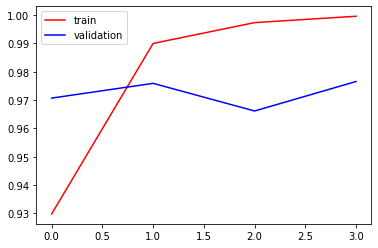

In [ ]:
import matplotlib.pyplot as plt

plt.plot(vgg_history.history['accuracy'],color='red',label='train')
plt.plot(vgg_history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

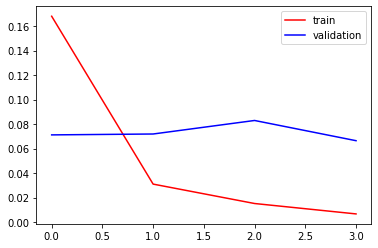

In [ ]:
plt.plot(vgg_history.history['loss'],color='red',label='train')
plt.plot(vgg_history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
# import pickle

In [ ]:
# pickle.dump(model_vgg,open('model_vgg.pkl','wb'))